# Evaluation using naively-trained discriminator

1. Train the discriminator on CIFAR10
2. Load the generator network with pretrained weights
3. Test discriminator with generated images

In [1]:
from __future__ import print_function
import pdb
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torch.autograd as autograd
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import numpy as np

In [2]:
nc = 3
batchSize=512
imageSize=32
nz=100
ngf=48
ndf=48
niter=500
lr=0.001
beta1=0.5
outf = './results_naive'

In [24]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

In [25]:
dataset = dset.CIFAR10(root="./data", download=True,
                        transform=transforms.Compose([
                        transforms.Scale(imageSize),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
                                         shuffle=True, num_workers=int(1))

Files already downloaded and verified


1. Define discriminator and generator networks

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


class _netG(nn.Module):
    def __init__(self, ngpu):
        super(_netG, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ngf, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 48 x 32 x 32
            nn.Conv2d(ngf, ngf, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 48 x 32 x 32
            nn.Conv2d(ngf, ngf, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 48 x 32 x 32
            nn.Conv2d(ngf, ngf, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 48 x 32 x 32
            nn.Conv2d(ngf, ngf, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 48 x 32 x 32
            nn.Conv2d(ngf, ngf, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 48 x 32 x 32
            nn.Conv2d(ngf, ngf, 1, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 3 x 32 x 32
            nn.Conv2d(ngf, nc, 1, 1, 0, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


# netG = _netG(1)
# netG.apply(weights_init)
# if opt.netG != '':
#     netG.load_state_dict(torch.load(opt.netG))
# print(netG)


class _netD(nn.Module):
    def __init__(self, ngpu):
        super(_netD, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*2, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*2, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*2, 1, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, 10, 1, 1, 1, bias=False),
            nn.AvgPool2d((8,8)),
            nn.Softmax()
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.squeeze()
    
#Load pretrained discriminator weights (naive training)
netD = _netD(1)
netD.apply(weights_init)
netD.load_state_dict(torch.load('./results_naive/netD_epoch_41.pth'))
print(netD)

criterion = nn.CrossEntropyLoss()

_netD(
  (main): Sequential(
    (0): Conv2d (3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): LeakyReLU(0.2, inplace)
    (2): Conv2d (48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(0.2, inplace)
    (4): Conv2d (48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): LeakyReLU(0.2, inplace)
    (6): Conv2d (96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): LeakyReLU(0.2, inplace)
    (8): Conv2d (96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): LeakyReLU(0.2, inplace)
    (10): Conv2d (96, 96, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1), bias=False)
    (11): LeakyReLU(0.2, inplace)
    (12): Conv2d (96, 10, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1), bias=False)
    (13): AvgPool2d(kernel_size=(8, 8), stride=(8, 8), padding=0, ceil_mode=False, count_include_pad=True)
    (14): Softmax()
  )
)


In [6]:
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

In [7]:
dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!

In [8]:
input = torch.FloatTensor(batchSize, 3, imageSize, imageSize)
#fixed_noise = torch.FloatTensor(opt.batchSize, nz, 1, 1).normal_(0, 1)
label = torch.FloatTensor(batchSize)
real_label = 1
fake_label = 0

In [9]:
use_cuda = False#torch.cuda.is_available()
if use_cuda:
    netD.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()

For training discriminator naively, no need to run unless to train further than epoch 41

In [10]:
for epoch in range(niter):
    for i, batch in enumerate(dataloader):
        data, classes = batch[0], batch[1]
       # print(data.size())
       # print(classes.size())
        ############################
        # (1) Update D network: 
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data
        batch_size = real_cpu.size(0)
        if use_cuda:
            real_cpu = real_cpu.cuda()
        input.resize_as_(real_cpu).copy_(real_cpu)
        label.resize_(batch_size).fill_(real_label)
        inputv = Variable(input)
        if use_cuda:
            labelv = Variable(classes).cuda()
        else:
            labelv = Variable(classes)
        #print(inputv.size())
        output = netD(inputv)
        errD_real = criterion(output, labelv)
        errD_real.backward()
        D_x = output.data.mean()
        optimizerD.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f D(x): %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD_real.data[0], D_x))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)

    # do checkpointing
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))


/home/romina/anaconda3/envs/py27/lib/python2.7/site-packages/torch/nn/modules/container.py:72: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[0/500][0/98] Loss_D: 1.8277 D(x): 0.1000
[0/500][1/98] Loss_D: 1.7699 D(x): 0.1000
[0/500][2/98] Loss_D: 1.8022 D(x): 0.1000
[0/500][3/98] Loss_D: 1.7786 D(x): 0.1000
[0/500][4/98] Loss_D: 1.7937 D(x): 0.1000
[0/500][5/98] Loss_D: 1.7615 D(x): 0.1000
[0/500][6/98] Loss_D: 1.7885 D(x): 0.1000
[0/500][7/98] Loss_D: 1.7646 D(x): 0.1000


Process Process-1:
Traceback (most recent call last):
  File "/home/romina/anaconda3/envs/py27/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/home/romina/anaconda3/envs/py27/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/romina/anaconda3/envs/py27/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/home/romina/anaconda3/envs/py27/lib/python2.7/multiprocessing/queues.py", line 376, in get
    return recv()
  File "/home/romina/anaconda3/envs/py27/lib/python2.7/site-packages/torch/multiprocessing/queue.py", line 21, in recv
    buf = self.recv_bytes()
KeyboardInterrupt


KeyboardInterrupt: 

Load generator weights from previous training

In [11]:
netG = _netG(1)
netG.apply(weights_init)
if use_cuda:
    netG.cuda()
#if opt.netG != '':
#torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))
loaded =torch.load('/home/romina/atgan/dcgan/results/netG_epoch_499.pth')
netG.load_state_dict(loaded)
print(netG)

_netG(
  (main): Sequential(
    (0): Conv2d (3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): LeakyReLU(0.2, inplace)
    (2): Conv2d (48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): LeakyReLU(0.2, inplace)
    (4): Conv2d (48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): LeakyReLU(0.2, inplace)
    (6): Conv2d (48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): LeakyReLU(0.2, inplace)
    (8): Conv2d (48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): LeakyReLU(0.2, inplace)
    (10): Conv2d (48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): LeakyReLU(0.2, inplace)
    (12): Conv2d (48, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (13): LeakyReLU(0.2, inplace)
    (14): Conv2d (48, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (15): Tanh()
  )
)


# Testing 

Now test both discriminators on generated attacks

Load Data

In [88]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = dset.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


In [ ]:
# get some random training images
dataiter = iter(dataloader)
images, labels = dataiter.next()

In [89]:
import matplotlib.pyplot as plt
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Process Process-18:
Traceback (most recent call last):
  File "/home/romina/anaconda3/envs/py27/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/home/romina/anaconda3/envs/py27/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/romina/anaconda3/envs/py27/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/home/romina/anaconda3/envs/py27/lib/python2.7/multiprocessing/queues.py", line 376, in get
    return recv()
  File "/home/romina/anaconda3/envs/py27/lib/python2.7/site-packages/torch/multiprocessing/queue.py", line 21, in recv
    buf = self.recv_bytes()
KeyboardInterrupt


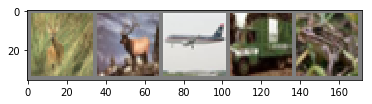

In [90]:
# show images
imshow(vutils.make_grid(images[5:10]))
plt.show()

In [91]:
# print labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(labels[5:10])
print(' '.join('%5s' % classes[labels[j]] for j in range(5,10)))


 4
 4
 0
 9
 6
[torch.LongTensor of size 5]

 deer  deer plane truck  frog


#### Generate some fake images

In [95]:
ginputv = Variable(images[5:10])
ginputv.requires_grad = True
glabelv = Variable(labels[5:10])
goutput = netD(ginputv)
errD_real = criterion(goutput, glabelv)    
errD_real.backward(retain_graph=True)

        # train with fake
        #noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        #noisev = Variable(noise)

fake = netG(Variable(ginputv.grad.data))
print(torch.norm(fake,float('inf')))
print(torch.norm(fake,2)/torch.norm(ginputv,2))

#generated = netG(Variable(images[5,10]))

Variable containing:
 1
[torch.FloatTensor of size 1]

Variable containing:
 0.6549
[torch.FloatTensor of size 1]



##### Show fake images

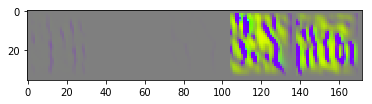

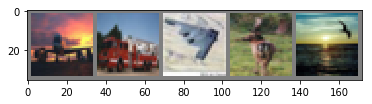

ValueError: Floating point image RGB values must be in the 0..1 range.

In [78]:
imshow(vutils.make_grid(fake.data))
plt.show()
imshow(vutils.make_grid((images[5:10])))
plt.show()
#print(images[5:10])
#print(fake.data.size())
#print(fake.data)
#perturbed = (images[5:10] + 10*fake.data) + 10
perturbed = (images[5:10] + 0.16*fake.data)
#print(perturbed)
imshow(vutils.make_grid(perturbed))
plt.show()

### Test naively trained discriminator on original, then on perturbed images

In [79]:
outputs = netD(Variable(images[5:10]))

In [80]:
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(5)))

Predicted:  truck truck plane  deer truck


In [81]:
outputs2 = netD(Variable(perturbed))

In [82]:
_, predicted2 = torch.max(outputs2.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted2[j]]
                              for j in range(5)))

Predicted:  truck truck plane  deer  bird


Find overall accuracy on original test set

In [57]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = netD(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 61 %


Find overall accuracy on adversarial (perturbed) test set for varying multiples of how much perturbation to add (i.e. [0.0 - 1.0] * perturbation + original)--> called "perturbation power" in paper

In [99]:
correct = [0 for i in range(0,10)]
total = [0 for i in range(0,10)]
accuracy = [0 for i in range(0,10)]
for p_i in range(0,10):
    for data in testloader:
        images, labels = data
        ginputv = Variable(images)
        ginputv.requires_grad = True
        glabelv = Variable(labels)
        goutput = netD(ginputv)
        errD_real = criterion(goutput, glabelv)    
        errD_real.backward(retain_graph=True)

            # train with fake
            #noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
            #noisev = Variable(noise)

        fake = netG(Variable(ginputv.grad.data))
        perturbed = p_i*0.1*fake + ginputv
        outputs = netD(perturbed)
        _, predicted = torch.max(outputs.data, 1)
        total[p_i] += labels.size(0)
        correct[p_i] += (predicted == labels).sum()
    accuracy[p_i] = 100*correct[p_i]/total[p_i]
    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct[p_i] / total[p_i]))

Accuracy of the network on the 10000 test images: 61 %
Accuracy of the network on the 10000 test images: 75 %
Accuracy of the network on the 10000 test images: 72 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 65 %
Accuracy of the network on the 10000 test images: 63 %
Accuracy of the network on the 10000 test images: 61 %
Accuracy of the network on the 10000 test images: 60 %
Accuracy of the network on the 10000 test images: 59 %
Accuracy of the network on the 10000 test images: 58 %


# Test on adversarially trained discriminator

Load weights from trained discriminator

In [117]:
netD_2 = _netD(1)
#netD_2.apply(weights_init)
if use_cuda:
    netD_2.cuda()
#if opt.netG != '':
#torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))
loaded =torch.load('/home/romina/atgan/dcgan/results/netD_epoch_499.pth')
netD_2.load_state_dict(loaded)
print(netD_2)

_netD(
  (main): Sequential(
    (0): Conv2d (3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): LeakyReLU(0.2, inplace)
    (2): Conv2d (48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(0.2, inplace)
    (4): Conv2d (48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): LeakyReLU(0.2, inplace)
    (6): Conv2d (96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): LeakyReLU(0.2, inplace)
    (8): Conv2d (96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): LeakyReLU(0.2, inplace)
    (10): Conv2d (96, 96, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1), bias=False)
    (11): LeakyReLU(0.2, inplace)
    (12): Conv2d (96, 10, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1), bias=False)
    (13): AvgPool2d(kernel_size=(8, 8), stride=(8, 8), padding=0, ceil_mode=False, count_include_pad=True)
    (14): Softmax()
  )
)


Find disc output on adversarial images

In [118]:
outputs_joint_trained = netD_2(Variable(perturbed))

RuntimeError: Variable data has to be a tensor, but got Variable

In [85]:
_, predicted_joint_trained = torch.max(outputs_joint_trained.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted_joint_trained[j]]
                              for j in range(5)))

Predicted:  truck plane plane  deer truck


Load data again

In [119]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = dset.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


Find overall accuracy of discriminator on adversarial images for varying multiples of how much perturbation to add (i.e. [0.0 - 1.0] * perturbation + original)--> called "perturbation power" in paper

In [120]:
correct_2 = [0 for i in range(0,10)]
total_2 = [0 for i in range(0,10)]
accuracy_2 = [0 for i in range(0,10)]
for p_i in range(0,10):
    for data in testloader:
        images, labels = data
        ginputv = Variable(images)
        ginputv.requires_grad = True
        glabelv = Variable(labels)
        goutput = netD_2(ginputv)
        errD_real = criterion(goutput, glabelv)    
        errD_real.backward(retain_graph=True)

            # train with fake
            #noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
            #noisev = Variable(noise)

        fake = netG(Variable(ginputv.grad.data))
        perturbed = p_i*0.1*fake + ginputv
        outputs = netD_2(perturbed)
        _, predicted = torch.max(outputs.data, 1)
        total_2[p_i] += labels.size(0)
        correct_2[p_i] += (predicted == labels).sum()
    accuracy_2[p_i] = 100*correct_2[p_i]/total_2[p_i]
    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct_2[p_i] / total_2[p_i]))

Accuracy of the network on the 10000 test images: 44 %
Accuracy of the network on the 10000 test images: 63 %
Accuracy of the network on the 10000 test images: 56 %
Accuracy of the network on the 10000 test images: 50 %
Accuracy of the network on the 10000 test images: 47 %
Accuracy of the network on the 10000 test images: 45 %
Accuracy of the network on the 10000 test images: 43 %
Accuracy of the network on the 10000 test images: 42 %
Accuracy of the network on the 10000 test images: 42 %
Accuracy of the network on the 10000 test images: 41 %


In [106]:
accuracy

[61, 75, 72, 68, 65, 63, 61, 60, 59, 58]

In [107]:
accuracy_2

[61, 75, 72, 68, 65, 63, 61, 60, 59, 58]

In [109]:
accuracy_2 = [100 * correct_2[i] / total_2[i] for i in range(0,10)]

In [110]:
accuracy_2

[44, 63, 56, 50, 47, 45, 43, 42, 42, 41]

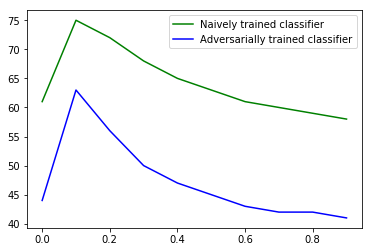

In [132]:
plt.plot([i*0.1 for i in range(0,10)], accuracy, 'g-',label='Naively trained classifier')
plt.plot([i*0.1 for i in range(0,10)], accuracy_2, 'b-',label='Adversarially trained classifier')
plt.legend()
plt.show()